In [ ]:
!pip install pytorch_fid

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
import gc
import matplotlib.pyplot as plt
import numpy as np
import os
import torchvision
import scipy.linalg
from scipy.linalg import sqrtm
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Define the custom dataset class

file_name = "/content/drive/MyDrive/sh3_sc6_y32_x32_imgs.npz"

# Define the VAE class
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True),
            #nn.Conv2d(64, 256, kernel_size=4, stride=2, padding=1),
            nn.Conv2d(64, 256, kernel_size=4),
            nn.ReLU(inplace=True),
            nn.Flatten(),
            #nn.Linear(512, 256),
            nn.Linear(256, 256),
            nn.Linear(256, 20) # Assuming we have a latent space of size 10 for mean and 10 for log-variance
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(10, 256),
            nn.Unflatten(-1, (256, 1, 1)),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(256, 64, kernel_size=4),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(32, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1)   # Use sigmoid for Bernoulli reconstruction
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(logvar)
        return mu + eps * std

    def forward(self, x):
        # Encode
        encoded = self.encoder(x)
        mu, logvar = torch.split(encoded, 10, dim=-1)
        z = self.reparameterize(mu, logvar)
        # Decode
        return self.decoder(z), mu, logvar
# Function for freeing up memory

In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset, SubsetRandomSampler
import numpy as np

batch_size=64
file_name = "/content/drive/MyDrive/sh3_sc6_y32_x32_imgs.npz"
imgs = np.load(file_name, allow_pickle=True, encoding='latin1')
imgs = imgs['imgs']

img_tensor = torch.from_numpy(imgs).float()
img_tensor = img_tensor.unsqueeze(1)
dataset = TensorDataset(img_tensor)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

Epoch 0, Loss: 16.67406752374437
Epoch 1, Loss: 6.995693932804796
Epoch 2, Loss: 2.708368548502525
Epoch 3, Loss: 1.9125954479806953
Epoch 4, Loss: 1.810822792765167
Epoch 5, Loss: 1.7505606566038396
Epoch 6, Loss: 1.7133798793786101
Epoch 7, Loss: 1.6808434087369177
Epoch 8, Loss: 1.6541265042291746
Epoch 9, Loss: 1.6232076494230165
Epoch 10, Loss: 1.5846823640167713
Epoch 11, Loss: 1.5235363245010376
Epoch 12, Loss: 1.4357667904761102
Epoch 13, Loss: 1.3436370525095198
Epoch 14, Loss: 1.2722308391498194
Epoch 15, Loss: 1.2210871540009975
Epoch 16, Loss: 1.1774641974932618
Epoch 17, Loss: 1.1437366021176179
Epoch 18, Loss: 1.1149545922461483
Epoch 19, Loss: 1.0887732439570956
Epoch 20, Loss: 1.0647154011660152
Epoch 21, Loss: 1.043431792822149
Epoch 22, Loss: 1.022958128609591
Epoch 23, Loss: 1.0036531930996313
Epoch 24, Loss: 0.986858894634578
Epoch 25, Loss: 0.972581770684984
Epoch 26, Loss: 0.9575715081559287
Epoch 27, Loss: 0.9458715212013986
Epoch 28, Loss: 0.9244746629976563
Epo

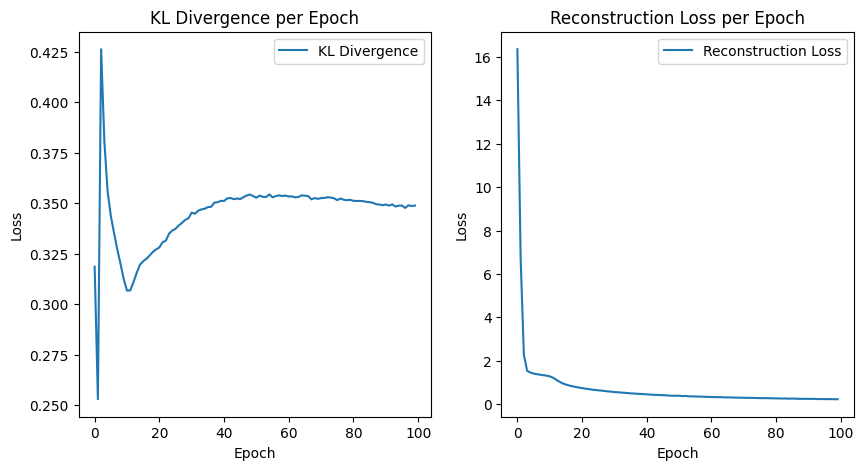

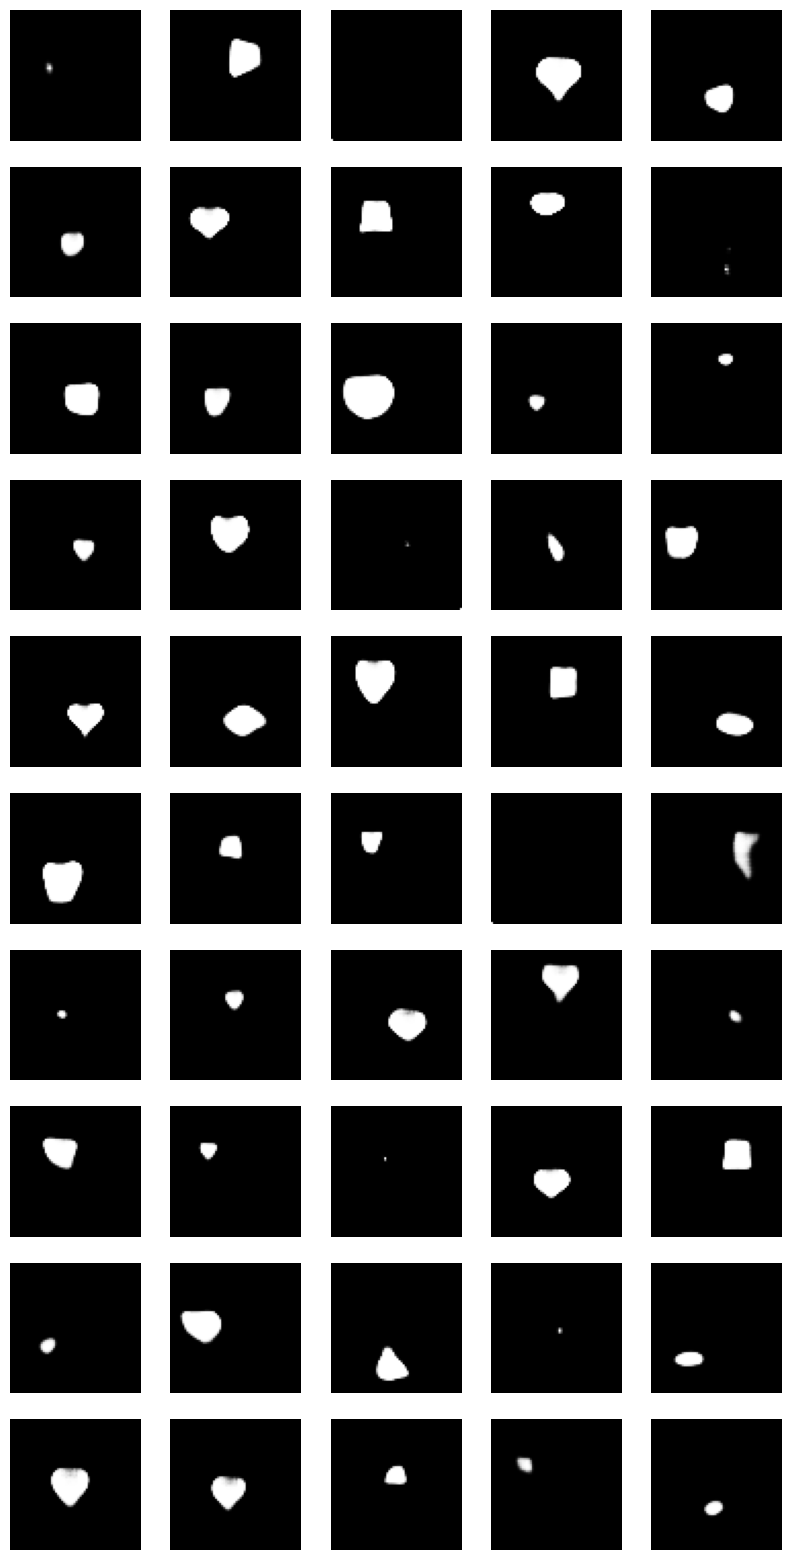

In [ ]:

# Function to save a grid of images
def save_image_grid(tensor, filename, nrows=10, ncols=5):
    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols, nrows))
    for i, ax in enumerate(axes.flat):
        ax.imshow(torch.tanh(tensor[i]).squeeze().cpu().numpy(), cmap='gray')
        ax.axis('off')
    plt.savefig(filename, bbox_inches='tight')
    plt.close(fig)

# Dataset and DataLoader

# Device Configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Model and Optimizer Initialization
vae = VAE().to(device)
optimizer = optim.Adam(vae.parameters(), lr=0.0001)
# Directory for saving images
image_dir = "/content/"
os.makedirs(image_dir, exist_ok=True)

# Initialize lists for storing losses
kl_losses = []
recon_losses = []
epochs = 100
critication=nn.BCEWithLogitsLoss(reduction='sum')
# Train the model and track losses
for epoch in range(epochs):
    train_loss = 0
    epoch_kl_loss = 0
    epoch_recon_loss = 0

    for batch_idx, data in enumerate(data_loader):
        data = data[0].to(device)  # Move data to GPU
        optimizer.zero_grad()

        reconstruction, mu, logvar = vae(data)
        recon_loss = critication(reconstruction, data)/batch_size
        kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())/batch_size
        loss = recon_loss + kl_div

        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        epoch_kl_loss += kl_div.item()
        epoch_recon_loss += recon_loss.item()

    average_loss = train_loss / len(data_loader.dataset)
    print(f"Epoch {epoch}, Loss: {average_loss}")
    kl_losses.append(epoch_kl_loss / len(data_loader.dataset))
    recon_losses.append(epoch_recon_loss / len(data_loader.dataset))

    # Generate and save a 10x5 grid of images at the end of each epoch
    vae.eval()  # Set the VAE to evaluation mode
    with torch.no_grad():
        sample = torch.randn(50, 10).to(device)  # Generate random latent vectors on GPU
        generated_images = vae.decoder(sample)
        save_image_grid(generated_images, os.path.join(image_dir, f'epoch_{epoch}_grid.png'))
    vae.train()


# Plot KL and reconstruction losses
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(kl_losses, label='KL Divergence')
plt.title('KL Divergence per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(recon_losses, label='Reconstruction Loss')
plt.title('Reconstruction Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Generate images
vae.eval()  # Set the VAE to evaluation mode
with torch.no_grad():
    sample = torch.randn(50, 10).to(device)  # Generate 50 random latent vectors on GPU
    generated_images = vae.decoder(sample)

# Plot a grid of images
fig, axes = plt.subplots(10, 5, figsize=(10, 20))
for i, ax in enumerate(axes.flat):
    ax.imshow(torch.sigmoid(generated_images[i]).squeeze().cpu().numpy(), cmap='gray')
    ax.axis('off')
plt.show()

from torchvision.models import inception_v3



In [ ]:
import os
from pytorch_fid.fid_score import calculate_fid_given_paths

def save_images(dataset, model, device, path_real, path_recon, batch_size=50):
    model.eval()
    real_images, recon_images = [], []

    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    with torch.no_grad():
        for i, (images,) in enumerate(dataloader, start=1):
            latent_samples = torch.randn(batch_size, 10).to(device)
            recon = torch.sigmoid(model.decoder(latent_samples)).cpu().numpy()

            for j in range(images.size(0)):
                real_images.append(images[j].squeeze().cpu().numpy())
                recon_images.append(recon[j].squeeze())

    os.makedirs(path_real, exist_ok=True)
    os.makedirs(path_recon, exist_ok=True)

    for i in range(len(real_images)):
        real_path = os.path.join(path_real, f"real_image_{i:05d}.png")
        recon_path = os.path.join(path_recon, f"recon_image_{i:05d}.png")
        plt.imsave(real_path, real_images[i], cmap="gray")
        plt.imsave(recon_path, recon_images[i], cmap="gray")

path_real = "real_images"
path_recon = "recon_images"

save_images(dataset, vae, device, path_real, path_recon, batch_size=batch_size)

fid_value = calculate_fid_given_paths([path_real, path_recon], batch_size=batch_size, device=device, dims=2048)
print(f'Simple VAE FID score: {fid_value}')

Downloading: "https://github.com/mseitzer/pytorch-fid/releases/download/fid_weights/pt_inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/pt_inception-2015-12-05-6726825d.pth
100%|██████████| 91.2M/91.2M [00:00<00:00, 255MB/s]
100%|██████████| 288/288 [01:11<00:00,  4.00it/s]


Simple VAE FID score: 97.33269255770063


# Control VAE

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt
from torchvision.models import inception_v3
from torchvision.transforms import functional as TF
import torch.nn.functional as F
import gc
import os
import scipy

# Device Configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Define the custom dataset class
class CustomDataset(Dataset):
    def __init__(self, npz_file, reduce_factor=10):
        self.data = np.load(npz_file, allow_pickle=True, encoding='latin1')['imgs']
        self.data = self.data[::reduce_factor]
        self.data = torch.tensor(self.data, dtype=torch.float).unsqueeze(1)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]
file_name = "/content/drive/MyDrive/dsprites_ndarray_co1sh3sc6or40x32y32_64x64.npz"

# dataset = CustomDataset(file_name, reduce_factor=100)

# # Optimize DataLoader
# batch_size = 64
# data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define the VAE class
# Define the VAE class
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True),
            #nn.Conv2d(64, 256, kernel_size=4, stride=2, padding=1),
            nn.Conv2d(64, 256, kernel_size=4),
            nn.ReLU(inplace=True),
            nn.Flatten(),
            #nn.Linear(512, 256),
            nn.Linear(256, 256),
            nn.Linear(256, 20) # Assuming we have a latent space of size 10 for mean and 10 for log-variance
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(10, 256),
            nn.Unflatten(-1, (256, 1, 1)),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(256, 64, kernel_size=4),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(32, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1)   # Use sigmoid for Bernoulli reconstruction
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(logvar)
        return mu + eps * std

    def forward(self, x):
        # Encode
        encoded = self.encoder(x)
        mu, logvar = torch.split(encoded, 10, dim=-1)
        z = self.reparameterize(mu, logvar)
        # Decode
        return self.decoder(z), mu, logvar



Training with desired KL divergence: 8
Epoch 0: Total Loss: 2798.3332, KL Loss: 1193.6728, Reconstruction Loss: 2798.3332, Beta: 1.0000


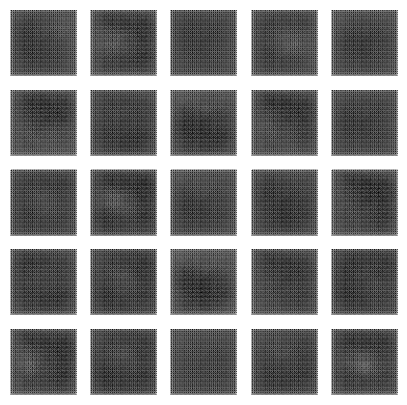

<Figure size 640x480 with 0 Axes>

Epoch 1: Total Loss: 1395.8197, KL Loss: 74.8857, Reconstruction Loss: 1320.9340, Beta: 1.0000
Epoch 2: Total Loss: 1321.9300, KL Loss: 22.5962, Reconstruction Loss: 1299.3338, Beta: 1.0000
Epoch 3: Total Loss: 1300.3060, KL Loss: 21.5761, Reconstruction Loss: 1278.7299, Beta: 1.0000
Epoch 4: Total Loss: 1279.6883, KL Loss: 20.8148, Reconstruction Loss: 1258.8735, Beta: 1.0000
Epoch 5: Total Loss: 1265.9601, KL Loss: 20.7665, Reconstruction Loss: 1245.1936, Beta: 1.0000
Epoch 6: Total Loss: 1259.2442, KL Loss: 20.5221, Reconstruction Loss: 1238.7221, Beta: 1.0000
Epoch 7: Total Loss: 1188.2211, KL Loss: 20.3476, Reconstruction Loss: 1167.8735, Beta: 1.0000
Epoch 8: Total Loss: 175.5111, KL Loss: 20.2690, Reconstruction Loss: 155.2422, Beta: 1.0000
Epoch 9: Total Loss: 169.5474, KL Loss: 20.1226, Reconstruction Loss: 149.4247, Beta: 1.0000
Epoch 10: Total Loss: 169.4336, KL Loss: 19.7181, Reconstruction Loss: 149.7155, Beta: 1.0000


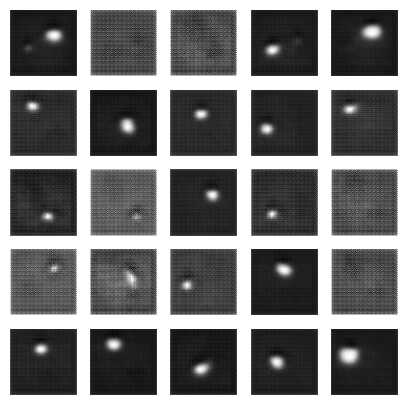

<Figure size 640x480 with 0 Axes>

Epoch 11: Total Loss: 163.6608, KL Loss: 19.4542, Reconstruction Loss: 144.2065, Beta: 1.0000
Epoch 12: Total Loss: 166.4796, KL Loss: 19.2097, Reconstruction Loss: 147.2699, Beta: 1.0000
Epoch 13: Total Loss: 163.4573, KL Loss: 18.9113, Reconstruction Loss: 144.5460, Beta: 1.0000
Epoch 14: Total Loss: 160.5693, KL Loss: 18.8636, Reconstruction Loss: 141.7057, Beta: 1.0000
Epoch 15: Total Loss: 161.0153, KL Loss: 18.9490, Reconstruction Loss: 142.0664, Beta: 1.0000
Epoch 16: Total Loss: 159.9601, KL Loss: 18.8267, Reconstruction Loss: 141.1334, Beta: 1.0000
Epoch 17: Total Loss: 158.3803, KL Loss: 19.1157, Reconstruction Loss: 139.2646, Beta: 1.0000
Epoch 18: Total Loss: 157.9181, KL Loss: 19.2391, Reconstruction Loss: 138.6790, Beta: 1.0000
Epoch 19: Total Loss: 161.3548, KL Loss: 19.4082, Reconstruction Loss: 141.9466, Beta: 1.0000
Epoch 20: Total Loss: 166.0377, KL Loss: 19.5412, Reconstruction Loss: 146.4965, Beta: 1.0000


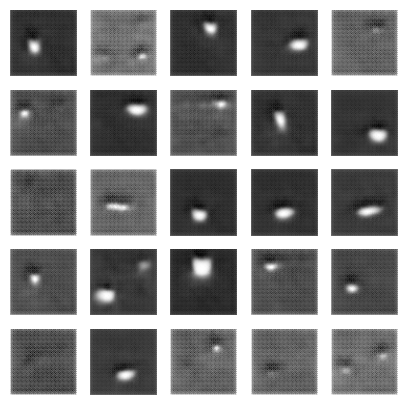

<Figure size 640x480 with 0 Axes>

Epoch 21: Total Loss: 162.9916, KL Loss: 19.5010, Reconstruction Loss: 143.4905, Beta: 1.0000
Epoch 22: Total Loss: 168.5967, KL Loss: 19.6345, Reconstruction Loss: 148.9622, Beta: 1.0000
Epoch 23: Total Loss: 165.1471, KL Loss: 19.5567, Reconstruction Loss: 145.5903, Beta: 1.0000
Epoch 24: Total Loss: 167.4707, KL Loss: 19.5578, Reconstruction Loss: 147.9129, Beta: 1.0000
Epoch 25: Total Loss: 160.4316, KL Loss: 19.5443, Reconstruction Loss: 140.8873, Beta: 1.0000
Epoch 26: Total Loss: 167.8253, KL Loss: 19.5412, Reconstruction Loss: 148.2841, Beta: 1.0000
Epoch 27: Total Loss: 162.3374, KL Loss: 19.5616, Reconstruction Loss: 142.7758, Beta: 1.0000
Epoch 28: Total Loss: 160.1585, KL Loss: 19.3987, Reconstruction Loss: 140.7598, Beta: 1.0000
Epoch 29: Total Loss: 162.4118, KL Loss: 19.3815, Reconstruction Loss: 143.0303, Beta: 1.0000
Epoch 30: Total Loss: 156.9984, KL Loss: 19.3786, Reconstruction Loss: 137.6198, Beta: 1.0000


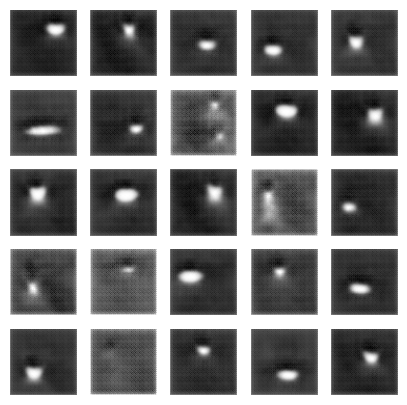

<Figure size 640x480 with 0 Axes>

Epoch 31: Total Loss: 161.4625, KL Loss: 19.2902, Reconstruction Loss: 142.1723, Beta: 1.0000
Epoch 32: Total Loss: 154.8622, KL Loss: 19.3023, Reconstruction Loss: 135.5599, Beta: 1.0000
Epoch 33: Total Loss: 153.2423, KL Loss: 19.3674, Reconstruction Loss: 133.8749, Beta: 1.0000
Epoch 34: Total Loss: 152.3345, KL Loss: 19.3204, Reconstruction Loss: 133.0141, Beta: 1.0000
Epoch 35: Total Loss: 150.8994, KL Loss: 19.3324, Reconstruction Loss: 131.5670, Beta: 1.0000
Epoch 36: Total Loss: 151.0941, KL Loss: 19.3230, Reconstruction Loss: 131.7710, Beta: 1.0000
Epoch 37: Total Loss: 146.3182, KL Loss: 19.2952, Reconstruction Loss: 127.0229, Beta: 1.0000
Epoch 38: Total Loss: 151.1938, KL Loss: 19.3889, Reconstruction Loss: 131.8048, Beta: 1.0000
Epoch 39: Total Loss: 143.7139, KL Loss: 19.3160, Reconstruction Loss: 124.3979, Beta: 1.0000
Epoch 40: Total Loss: 138.8770, KL Loss: 19.3285, Reconstruction Loss: 119.5485, Beta: 1.0000


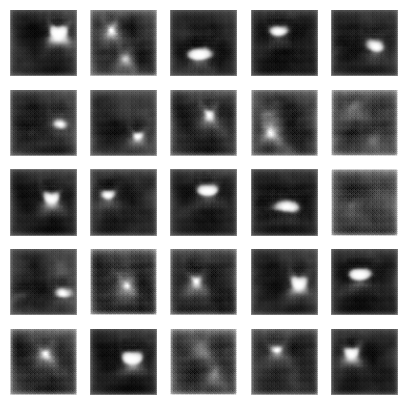

<Figure size 640x480 with 0 Axes>

Epoch 41: Total Loss: 134.8827, KL Loss: 19.3454, Reconstruction Loss: 115.5373, Beta: 1.0000
Epoch 42: Total Loss: 133.2442, KL Loss: 19.2892, Reconstruction Loss: 113.9550, Beta: 1.0000
Epoch 43: Total Loss: 134.2137, KL Loss: 19.2497, Reconstruction Loss: 114.9640, Beta: 1.0000
Epoch 44: Total Loss: 126.9113, KL Loss: 19.2172, Reconstruction Loss: 107.6941, Beta: 1.0000
Epoch 45: Total Loss: 126.4333, KL Loss: 19.2957, Reconstruction Loss: 107.1375, Beta: 1.0000
Epoch 46: Total Loss: 127.7200, KL Loss: 19.2665, Reconstruction Loss: 108.4535, Beta: 1.0000
Epoch 47: Total Loss: 127.1172, KL Loss: 19.2738, Reconstruction Loss: 107.8434, Beta: 1.0000
Epoch 48: Total Loss: 122.3684, KL Loss: 19.1883, Reconstruction Loss: 103.1801, Beta: 1.0000
Epoch 49: Total Loss: 119.4884, KL Loss: 19.1651, Reconstruction Loss: 100.3233, Beta: 1.0000
Epoch 50: Total Loss: 116.0776, KL Loss: 19.1733, Reconstruction Loss: 96.9043, Beta: 1.0000


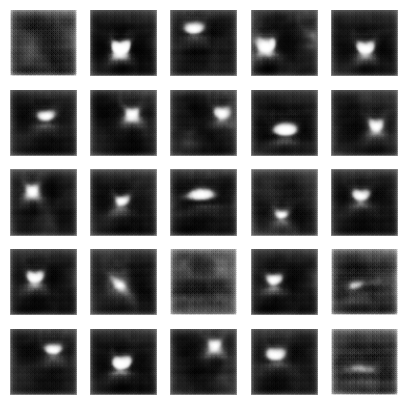

<Figure size 640x480 with 0 Axes>

Epoch 51: Total Loss: 119.9109, KL Loss: 19.2218, Reconstruction Loss: 100.6891, Beta: 1.0000
Epoch 52: Total Loss: 116.0969, KL Loss: 19.1241, Reconstruction Loss: 96.9728, Beta: 1.0000
Epoch 53: Total Loss: 114.5231, KL Loss: 19.0874, Reconstruction Loss: 95.4357, Beta: 1.0000
Epoch 54: Total Loss: 112.1886, KL Loss: 19.1697, Reconstruction Loss: 93.0190, Beta: 1.0000
Epoch 55: Total Loss: 110.4616, KL Loss: 19.0856, Reconstruction Loss: 91.3761, Beta: 1.0000
Epoch 56: Total Loss: 112.9927, KL Loss: 19.0892, Reconstruction Loss: 93.9036, Beta: 1.0000
Epoch 57: Total Loss: 112.2410, KL Loss: 19.2058, Reconstruction Loss: 93.0351, Beta: 1.0000
Epoch 58: Total Loss: 107.9253, KL Loss: 19.0809, Reconstruction Loss: 88.8444, Beta: 1.0000
Epoch 59: Total Loss: 106.0607, KL Loss: 19.0517, Reconstruction Loss: 87.0090, Beta: 1.0000
Epoch 60: Total Loss: 99.0903, KL Loss: 19.0616, Reconstruction Loss: 80.0287, Beta: 1.0000


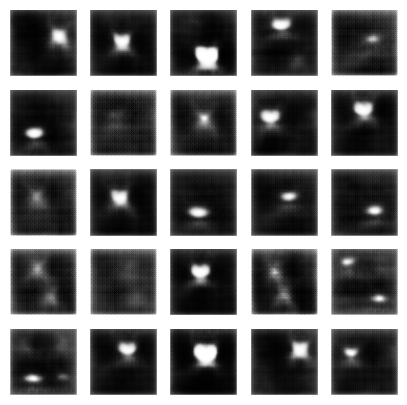

<Figure size 640x480 with 0 Axes>

Epoch 61: Total Loss: 108.2422, KL Loss: 19.0945, Reconstruction Loss: 89.1477, Beta: 1.0000
Epoch 62: Total Loss: 110.0158, KL Loss: 19.0146, Reconstruction Loss: 91.0012, Beta: 1.0000
Epoch 63: Total Loss: 100.4002, KL Loss: 18.9224, Reconstruction Loss: 81.4778, Beta: 1.0000
Epoch 64: Total Loss: 94.6530, KL Loss: 19.0984, Reconstruction Loss: 75.5546, Beta: 1.0000
Epoch 65: Total Loss: 98.1068, KL Loss: 19.0313, Reconstruction Loss: 79.0755, Beta: 1.0000
Epoch 66: Total Loss: 95.3746, KL Loss: 18.9086, Reconstruction Loss: 76.4660, Beta: 1.0000
Epoch 67: Total Loss: 92.4880, KL Loss: 18.8975, Reconstruction Loss: 73.5905, Beta: 1.0000
Epoch 68: Total Loss: 94.9947, KL Loss: 19.0686, Reconstruction Loss: 75.9261, Beta: 1.0000
Epoch 69: Total Loss: 90.9601, KL Loss: 18.9329, Reconstruction Loss: 72.0272, Beta: 1.0000
Epoch 70: Total Loss: 95.0767, KL Loss: 18.9988, Reconstruction Loss: 76.0780, Beta: 1.0000


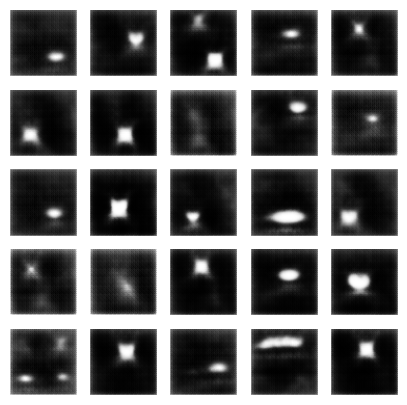

<Figure size 640x480 with 0 Axes>

Epoch 71: Total Loss: 91.6593, KL Loss: 18.9765, Reconstruction Loss: 72.6827, Beta: 1.0000
Epoch 72: Total Loss: 88.8347, KL Loss: 19.0044, Reconstruction Loss: 69.8303, Beta: 1.0000
Epoch 73: Total Loss: 89.7389, KL Loss: 19.0274, Reconstruction Loss: 70.7115, Beta: 1.0000
Epoch 74: Total Loss: 87.8316, KL Loss: 18.9950, Reconstruction Loss: 68.8367, Beta: 1.0000
Epoch 75: Total Loss: 86.6479, KL Loss: 18.9431, Reconstruction Loss: 67.7048, Beta: 1.0000
Epoch 76: Total Loss: 85.8841, KL Loss: 18.9484, Reconstruction Loss: 66.9356, Beta: 1.0000
Epoch 77: Total Loss: 87.7304, KL Loss: 18.8951, Reconstruction Loss: 68.8354, Beta: 1.0000
Epoch 78: Total Loss: 83.4011, KL Loss: 18.8610, Reconstruction Loss: 64.5401, Beta: 1.0000
Epoch 79: Total Loss: 86.2942, KL Loss: 18.9691, Reconstruction Loss: 67.3251, Beta: 1.0000
Epoch 80: Total Loss: 86.6880, KL Loss: 18.8960, Reconstruction Loss: 67.7920, Beta: 1.0000


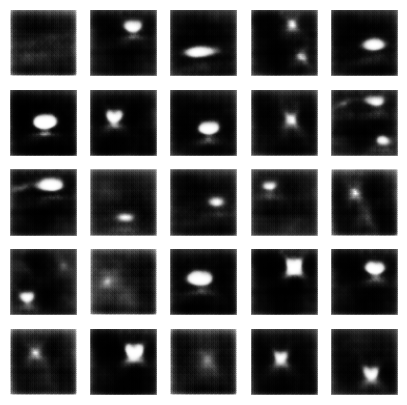

<Figure size 640x480 with 0 Axes>

Epoch 81: Total Loss: 82.8443, KL Loss: 18.8723, Reconstruction Loss: 63.9720, Beta: 1.0000
Epoch 82: Total Loss: 85.8186, KL Loss: 18.8037, Reconstruction Loss: 67.0148, Beta: 1.0000
Epoch 83: Total Loss: 81.0270, KL Loss: 18.8756, Reconstruction Loss: 62.1513, Beta: 1.0000
Epoch 84: Total Loss: 81.5366, KL Loss: 18.8957, Reconstruction Loss: 62.6410, Beta: 1.0000
Epoch 85: Total Loss: 79.5325, KL Loss: 18.7492, Reconstruction Loss: 60.7833, Beta: 1.0000
Epoch 86: Total Loss: 78.2122, KL Loss: 18.8305, Reconstruction Loss: 59.3817, Beta: 1.0000
Epoch 87: Total Loss: 81.4384, KL Loss: 18.8583, Reconstruction Loss: 62.5801, Beta: 1.0000
Epoch 88: Total Loss: 75.2281, KL Loss: 18.7415, Reconstruction Loss: 56.4866, Beta: 1.0000
Epoch 89: Total Loss: 75.2199, KL Loss: 18.7459, Reconstruction Loss: 56.4740, Beta: 1.0000
Epoch 90: Total Loss: 75.8610, KL Loss: 18.7563, Reconstruction Loss: 57.1047, Beta: 1.0000


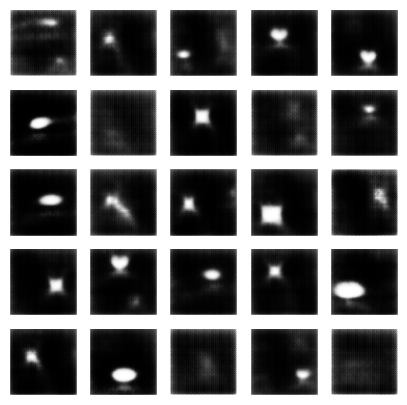

<Figure size 640x480 with 0 Axes>

Epoch 91: Total Loss: 79.1809, KL Loss: 18.7718, Reconstruction Loss: 60.4091, Beta: 1.0000
Epoch 92: Total Loss: 73.2055, KL Loss: 18.7931, Reconstruction Loss: 54.4125, Beta: 1.0000
Epoch 93: Total Loss: 74.1360, KL Loss: 18.7409, Reconstruction Loss: 55.3951, Beta: 1.0000
Epoch 94: Total Loss: 73.7520, KL Loss: 18.8363, Reconstruction Loss: 54.9157, Beta: 1.0000
Epoch 95: Total Loss: 70.4590, KL Loss: 18.8001, Reconstruction Loss: 51.6589, Beta: 1.0000
Epoch 96: Total Loss: 73.8343, KL Loss: 18.8104, Reconstruction Loss: 55.0239, Beta: 1.0000
Epoch 97: Total Loss: 70.5084, KL Loss: 18.7395, Reconstruction Loss: 51.7689, Beta: 1.0000
Epoch 98: Total Loss: 76.9618, KL Loss: 18.6850, Reconstruction Loss: 58.2768, Beta: 1.0000
Epoch 99: Total Loss: 71.7571, KL Loss: 18.6789, Reconstruction Loss: 53.0782, Beta: 1.0000
Training with desired KL divergence: 14
Epoch 0: Total Loss: 712.5646, KL Loss: 216.1412, Reconstruction Loss: 712.5646, Beta: 0.2121


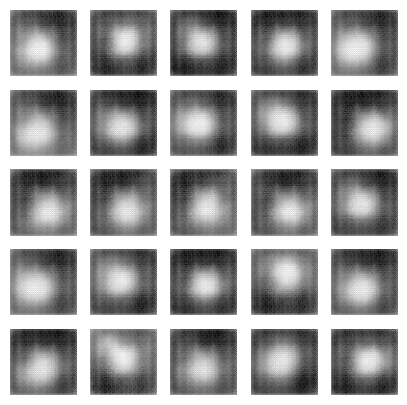

<Figure size 640x480 with 0 Axes>

Epoch 1: Total Loss: 287.9447, KL Loss: 105.4090, Reconstruction Loss: 265.5831, Beta: 0.3036
Epoch 2: Total Loss: 194.1890, KL Loss: 45.4091, Reconstruction Loss: 180.4050, Beta: 0.3350
Epoch 3: Total Loss: 185.0514, KL Loss: 36.7623, Reconstruction Loss: 172.7375, Beta: 0.3577
Epoch 4: Total Loss: 176.9513, KL Loss: 33.7940, Reconstruction Loss: 164.8625, Beta: 0.3775
Epoch 5: Total Loss: 174.6532, KL Loss: 31.9261, Reconstruction Loss: 162.6006, Beta: 0.3954
Epoch 6: Total Loss: 171.8659, KL Loss: 30.8478, Reconstruction Loss: 159.6674, Beta: 0.4123
Epoch 7: Total Loss: 167.8609, KL Loss: 30.1427, Reconstruction Loss: 155.4334, Beta: 0.4284
Epoch 8: Total Loss: 162.3582, KL Loss: 29.5379, Reconstruction Loss: 149.7033, Beta: 0.4440
Epoch 9: Total Loss: 163.5236, KL Loss: 28.9191, Reconstruction Loss: 150.6844, Beta: 0.4589
Epoch 10: Total Loss: 159.0475, KL Loss: 28.7624, Reconstruction Loss: 145.8488, Beta: 0.4737


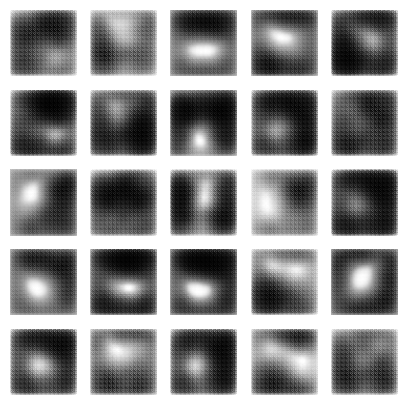

<Figure size 640x480 with 0 Axes>

Epoch 11: Total Loss: 157.8804, KL Loss: 28.5474, Reconstruction Loss: 144.3589, Beta: 0.4882
Epoch 12: Total Loss: 153.6013, KL Loss: 28.5861, Reconstruction Loss: 139.6456, Beta: 0.5028
Epoch 13: Total Loss: 155.8852, KL Loss: 28.9313, Reconstruction Loss: 141.3390, Beta: 0.5177
Epoch 14: Total Loss: 155.6989, KL Loss: 28.8774, Reconstruction Loss: 140.7487, Beta: 0.5326
Epoch 15: Total Loss: 150.5023, KL Loss: 28.7792, Reconstruction Loss: 135.1747, Beta: 0.5474
Epoch 16: Total Loss: 149.2574, KL Loss: 28.4182, Reconstruction Loss: 133.7020, Beta: 0.5618
Epoch 17: Total Loss: 150.1123, KL Loss: 28.2726, Reconstruction Loss: 134.2290, Beta: 0.5761
Epoch 18: Total Loss: 144.1650, KL Loss: 28.0616, Reconstruction Loss: 127.9997, Beta: 0.5901
Epoch 19: Total Loss: 143.6562, KL Loss: 27.8033, Reconstruction Loss: 127.2488, Beta: 0.6039
Epoch 20: Total Loss: 147.1118, KL Loss: 27.7016, Reconstruction Loss: 130.3820, Beta: 0.6176


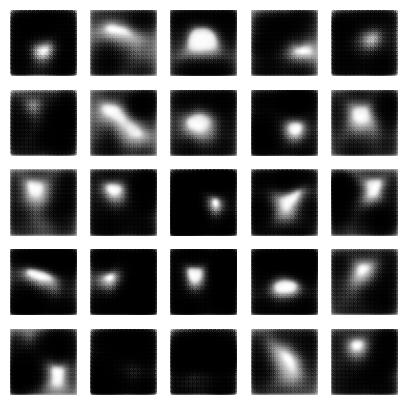

<Figure size 640x480 with 0 Axes>

Epoch 21: Total Loss: 145.1329, KL Loss: 27.5389, Reconstruction Loss: 128.1240, Beta: 0.6312
Epoch 22: Total Loss: 143.0237, KL Loss: 27.4869, Reconstruction Loss: 125.6748, Beta: 0.6447
Epoch 23: Total Loss: 136.6648, KL Loss: 27.4953, Reconstruction Loss: 118.9398, Beta: 0.6582
Epoch 24: Total Loss: 144.1200, KL Loss: 27.1128, Reconstruction Loss: 126.2757, Beta: 0.6713
Epoch 25: Total Loss: 135.4566, KL Loss: 27.3626, Reconstruction Loss: 117.0891, Beta: 0.6846
Epoch 26: Total Loss: 138.5695, KL Loss: 27.3140, Reconstruction Loss: 119.8696, Beta: 0.6979
Epoch 27: Total Loss: 131.3128, KL Loss: 27.3446, Reconstruction Loss: 112.2279, Beta: 0.7113
Epoch 28: Total Loss: 129.6053, KL Loss: 27.0116, Reconstruction Loss: 110.3923, Beta: 0.7243
Epoch 29: Total Loss: 130.2997, KL Loss: 27.1593, Reconstruction Loss: 110.6283, Beta: 0.7375
Epoch 30: Total Loss: 127.1980, KL Loss: 26.9906, Reconstruction Loss: 107.2937, Beta: 0.7504


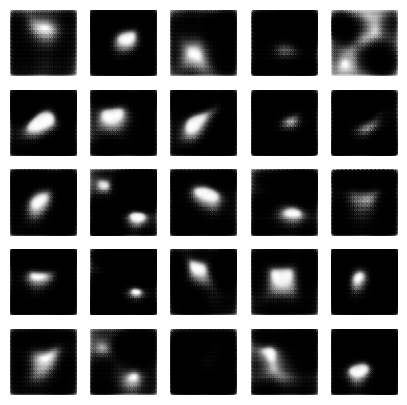

<Figure size 640x480 with 0 Axes>

Epoch 31: Total Loss: 126.0314, KL Loss: 27.1326, Reconstruction Loss: 105.6698, Beta: 0.7636
Epoch 32: Total Loss: 119.5951, KL Loss: 27.1540, Reconstruction Loss: 98.8609, Beta: 0.7767
Epoch 33: Total Loss: 121.1692, KL Loss: 27.1412, Reconstruction Loss: 100.0878, Beta: 0.7899
Epoch 34: Total Loss: 117.6759, KL Loss: 26.9044, Reconstruction Loss: 96.4248, Beta: 0.8028
Epoch 35: Total Loss: 111.8849, KL Loss: 26.9220, Reconstruction Loss: 90.2725, Beta: 0.8157
Epoch 36: Total Loss: 110.4650, KL Loss: 26.8556, Reconstruction Loss: 88.5588, Beta: 0.8286
Epoch 37: Total Loss: 104.9091, KL Loss: 26.8187, Reconstruction Loss: 82.6883, Beta: 0.8414
Epoch 38: Total Loss: 104.7480, KL Loss: 26.8298, Reconstruction Loss: 82.1740, Beta: 0.8542
Epoch 39: Total Loss: 107.7827, KL Loss: 26.4975, Reconstruction Loss: 85.1483, Beta: 0.8667
Epoch 40: Total Loss: 99.3163, KL Loss: 26.4802, Reconstruction Loss: 76.3659, Beta: 0.8792


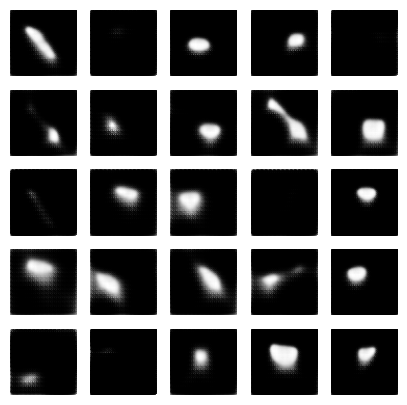

<Figure size 640x480 with 0 Axes>

Epoch 41: Total Loss: 101.3033, KL Loss: 26.5371, Reconstruction Loss: 77.9723, Beta: 0.8917
Epoch 42: Total Loss: 96.7807, KL Loss: 26.4489, Reconstruction Loss: 73.1957, Beta: 0.9042
Epoch 43: Total Loss: 97.6483, KL Loss: 26.2832, Reconstruction Loss: 73.8838, Beta: 0.9165
Epoch 44: Total Loss: 96.8793, KL Loss: 26.3083, Reconstruction Loss: 72.7690, Beta: 0.9288
Epoch 45: Total Loss: 94.3220, KL Loss: 26.1716, Reconstruction Loss: 70.0148, Beta: 0.9409
Epoch 46: Total Loss: 99.7473, KL Loss: 26.0189, Reconstruction Loss: 75.2654, Beta: 0.9530
Epoch 47: Total Loss: 94.0510, KL Loss: 25.9117, Reconstruction Loss: 69.3585, Beta: 0.9649
Epoch 48: Total Loss: 97.4061, KL Loss: 25.9209, Reconstruction Loss: 72.3960, Beta: 0.9768
Epoch 49: Total Loss: 95.6855, KL Loss: 25.8378, Reconstruction Loss: 70.4476, Beta: 0.9886
Epoch 50: Total Loss: 97.0892, KL Loss: 25.6154, Reconstruction Loss: 71.7652, Beta: 1.0000


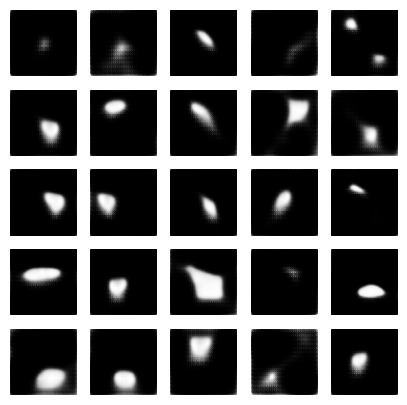

<Figure size 640x480 with 0 Axes>

Epoch 51: Total Loss: 96.7101, KL Loss: 25.5789, Reconstruction Loss: 71.1312, Beta: 1.0000
Epoch 52: Total Loss: 91.3096, KL Loss: 25.4284, Reconstruction Loss: 65.8812, Beta: 1.0000
Epoch 53: Total Loss: 93.1103, KL Loss: 25.4335, Reconstruction Loss: 67.6768, Beta: 1.0000
Epoch 54: Total Loss: 91.0561, KL Loss: 25.4216, Reconstruction Loss: 65.6345, Beta: 1.0000
Epoch 55: Total Loss: 91.0270, KL Loss: 25.4079, Reconstruction Loss: 65.6190, Beta: 1.0000
Epoch 56: Total Loss: 86.9790, KL Loss: 25.3786, Reconstruction Loss: 61.6005, Beta: 1.0000
Epoch 57: Total Loss: 90.9869, KL Loss: 25.2804, Reconstruction Loss: 65.7065, Beta: 1.0000
Epoch 58: Total Loss: 86.9166, KL Loss: 25.1947, Reconstruction Loss: 61.7220, Beta: 1.0000
Epoch 59: Total Loss: 90.7000, KL Loss: 25.2860, Reconstruction Loss: 65.4140, Beta: 1.0000
Epoch 60: Total Loss: 87.9495, KL Loss: 25.0344, Reconstruction Loss: 62.9151, Beta: 1.0000


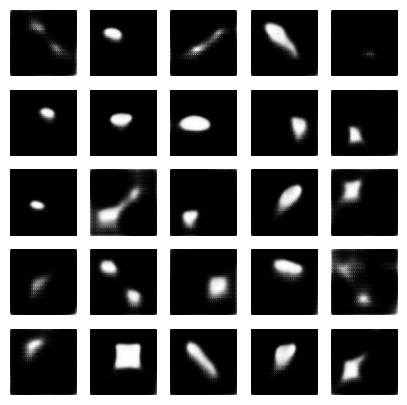

<Figure size 640x480 with 0 Axes>

Epoch 61: Total Loss: 90.3983, KL Loss: 25.1085, Reconstruction Loss: 65.2898, Beta: 1.0000
Epoch 62: Total Loss: 88.1802, KL Loss: 25.1193, Reconstruction Loss: 63.0610, Beta: 1.0000
Epoch 63: Total Loss: 84.8206, KL Loss: 24.9896, Reconstruction Loss: 59.8310, Beta: 1.0000
Epoch 64: Total Loss: 84.4937, KL Loss: 24.9516, Reconstruction Loss: 59.5421, Beta: 1.0000
Epoch 65: Total Loss: 89.4451, KL Loss: 24.9736, Reconstruction Loss: 64.4715, Beta: 1.0000
Epoch 66: Total Loss: 85.6495, KL Loss: 24.8569, Reconstruction Loss: 60.7926, Beta: 1.0000
Epoch 67: Total Loss: 87.1925, KL Loss: 24.9076, Reconstruction Loss: 62.2849, Beta: 1.0000
Epoch 68: Total Loss: 82.4499, KL Loss: 24.8278, Reconstruction Loss: 57.6221, Beta: 1.0000
Epoch 69: Total Loss: 84.7974, KL Loss: 24.6617, Reconstruction Loss: 60.1357, Beta: 1.0000
Epoch 70: Total Loss: 81.8157, KL Loss: 24.7860, Reconstruction Loss: 57.0297, Beta: 1.0000


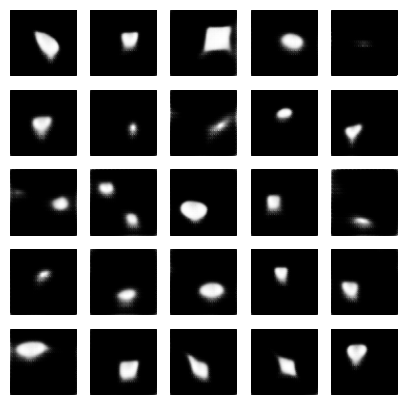

<Figure size 640x480 with 0 Axes>

Epoch 71: Total Loss: 83.3560, KL Loss: 24.6761, Reconstruction Loss: 58.6799, Beta: 1.0000
Epoch 72: Total Loss: 88.5540, KL Loss: 24.6640, Reconstruction Loss: 63.8899, Beta: 1.0000
Epoch 73: Total Loss: 84.3673, KL Loss: 24.5877, Reconstruction Loss: 59.7796, Beta: 1.0000
Epoch 74: Total Loss: 83.7387, KL Loss: 24.5677, Reconstruction Loss: 59.1710, Beta: 1.0000
Epoch 75: Total Loss: 79.0123, KL Loss: 24.5249, Reconstruction Loss: 54.4875, Beta: 1.0000
Epoch 76: Total Loss: 79.5235, KL Loss: 24.5583, Reconstruction Loss: 54.9651, Beta: 1.0000
Epoch 77: Total Loss: 80.8298, KL Loss: 24.4974, Reconstruction Loss: 56.3325, Beta: 1.0000
Epoch 78: Total Loss: 80.4178, KL Loss: 24.4690, Reconstruction Loss: 55.9489, Beta: 1.0000
Epoch 79: Total Loss: 79.5079, KL Loss: 24.5694, Reconstruction Loss: 54.9386, Beta: 1.0000
Epoch 80: Total Loss: 81.6323, KL Loss: 24.4552, Reconstruction Loss: 57.1770, Beta: 1.0000


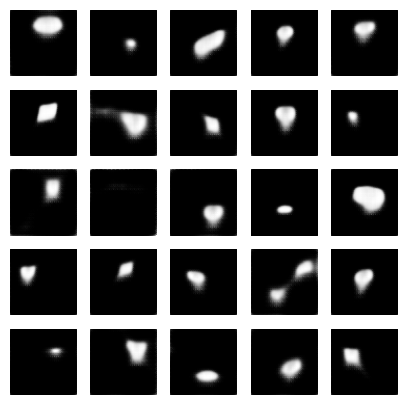

<Figure size 640x480 with 0 Axes>

Epoch 81: Total Loss: 79.1077, KL Loss: 24.3593, Reconstruction Loss: 54.7484, Beta: 1.0000
Epoch 82: Total Loss: 82.8389, KL Loss: 24.3238, Reconstruction Loss: 58.5151, Beta: 1.0000
Epoch 83: Total Loss: 82.4364, KL Loss: 24.2435, Reconstruction Loss: 58.1929, Beta: 1.0000
Epoch 84: Total Loss: 79.9800, KL Loss: 24.3433, Reconstruction Loss: 55.6367, Beta: 1.0000
Epoch 85: Total Loss: 77.4267, KL Loss: 24.3004, Reconstruction Loss: 53.1263, Beta: 1.0000
Epoch 86: Total Loss: 75.0595, KL Loss: 24.3011, Reconstruction Loss: 50.7583, Beta: 1.0000
Epoch 87: Total Loss: 78.5036, KL Loss: 24.1050, Reconstruction Loss: 54.3986, Beta: 1.0000
Epoch 88: Total Loss: 76.4570, KL Loss: 24.2460, Reconstruction Loss: 52.2110, Beta: 1.0000
Epoch 89: Total Loss: 74.0289, KL Loss: 24.1159, Reconstruction Loss: 49.9130, Beta: 1.0000
Epoch 90: Total Loss: 81.2313, KL Loss: 24.2401, Reconstruction Loss: 56.9912, Beta: 1.0000


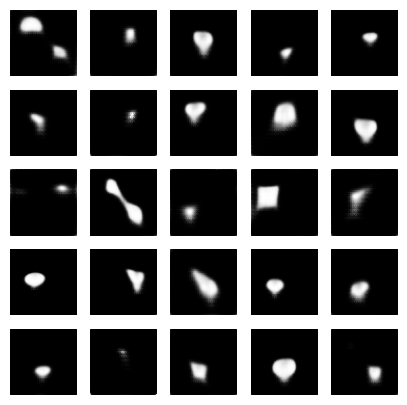

<Figure size 640x480 with 0 Axes>

Epoch 91: Total Loss: 72.6425, KL Loss: 24.0738, Reconstruction Loss: 48.5688, Beta: 1.0000
Epoch 92: Total Loss: 76.9869, KL Loss: 23.9435, Reconstruction Loss: 53.0435, Beta: 1.0000
Epoch 93: Total Loss: 79.4459, KL Loss: 24.0785, Reconstruction Loss: 55.3674, Beta: 1.0000
Epoch 94: Total Loss: 73.1739, KL Loss: 23.9860, Reconstruction Loss: 49.1879, Beta: 1.0000
Epoch 95: Total Loss: 74.2727, KL Loss: 24.0687, Reconstruction Loss: 50.2039, Beta: 1.0000
Epoch 96: Total Loss: 74.3670, KL Loss: 23.9785, Reconstruction Loss: 50.3885, Beta: 1.0000
Epoch 97: Total Loss: 76.4686, KL Loss: 23.9102, Reconstruction Loss: 52.5583, Beta: 1.0000
Epoch 98: Total Loss: 74.7411, KL Loss: 23.9523, Reconstruction Loss: 50.7887, Beta: 1.0000
Epoch 99: Total Loss: 71.5608, KL Loss: 23.8251, Reconstruction Loss: 47.7357, Beta: 1.0000


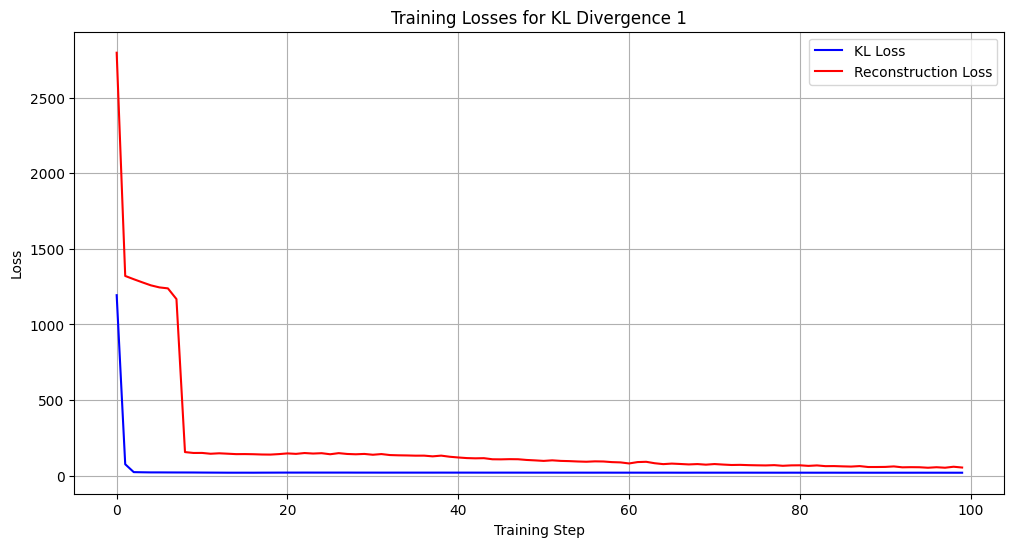

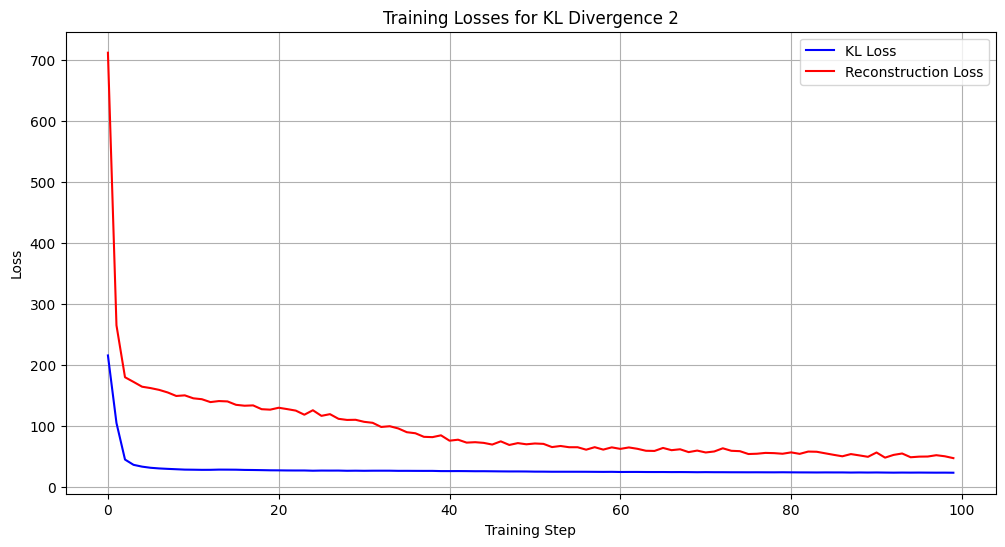

In [ ]:
# Instantiate the model and move it to the GPU
vae = VAE().to(device)

# Define optimizer
optimizer = optim.Adam(vae.parameters(), lr=0.0001)

# Function for freeing up memory

# Function to save a grid of images
def save_image_grid(tensor, filename, nrows=10, ncols=5):
    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols, nrows))
    for i, ax in enumerate(axes.flat):
        ax.imshow(tensor[i].squeeze().cpu().numpy(), cmap='gray')
        ax.axis('off')
    plt.savefig(filename, bbox_inches='tight')
    plt.close(fig)

# Directory for saving images
image_dir = "/Users/behradmousaie/Desktop/"
os.makedirs(image_dir, exist_ok=True)

# Function to calculate the FID score
def calculate_fid(real_features, generated_features):
    mu1, sigma1 = np.mean(real_features, axis=0), np.cov(real_features, rowvar=False)
    mu2, sigma2 = np.mean(generated_features, axis=0), np.cov(generated_features, rowvar=False)

    diff = mu1 - mu2

    # Product of the two covariances
    covmean, _ = scipy.linalg.sqrtm(sigma1.dot(sigma2), disp=False)
    if not np.isfinite(covmean).all():
        covmean = np.identity(sigma1.shape[0])

    # Calculate FID score
    fid = (diff.dot(diff) + np.trace(sigma1) + np.trace(sigma2) - 2 * np.trace(covmean))
    return fid

# Function for generating images from the VAE
def generate_images(model, num_images, device):
    model.eval()
    with torch.no_grad():
        z = torch.randn(num_images, 10).to(device)
        generated_images = model.decoder(z)
    return generated_images

def extract_features(model, data_loader, device):
    model.eval()
    features = []

    with torch.no_grad():
        for data in data_loader:
            # Resize data to 299x299 for Inception model
            data = TF.resize(data, (299, 299))

            data_rgb = data.repeat(1, 3, 1, 1).to(device)  # Convert to RGB
            feature = model(data_rgb)
            features.append(feature.cpu().numpy())

    features = np.concatenate(features, axis=0)
    return features


# Update function to match the PI algorithm from the provided image
def update_beta(t, e_t, I_prev, beta_prev, Kp, Ki, beta_min, beta_max):
    P_t = Kp / (1 + np.exp(e_t))  # Proportional term with logistic function for control
    if beta_min <= beta_prev <= beta_max:
        I_t = I_prev - Ki * e_t  # Integral term with anti-windup
    else:
        I_t = I_prev

    beta_t = P_t + I_t + beta_min
    beta_t = min(max(beta_t, beta_min), beta_max)  # Clamping beta within [beta_min, beta_max]
    return beta_t, I_t

# Define function to perform one training epoch with gradient clipping
def train_epoch(model, data_loader, optimizer, device, beta, max_grad_norm):
    model.train()
    total_loss = 0
    total_kl_loss = 0
    total_recon_loss = 0

    for batch_idx, data in enumerate(data_loader):
        data = data[0].to(device)  # Move data to GPU
        optimizer.zero_grad()

        # Forward pass
        reconstruction, mu, logvar = model(data)

        # Ensure values are in [0, 1]
        reconstruction = reconstruction.clamp(0, 1)

        # Compute losses
        recon_loss = F.binary_cross_entropy(reconstruction, data, reduction='sum')
        kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        loss = recon_loss + beta * kl_div

        # Backward pass
        loss.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)

        # Update parameters
        optimizer.step()

        total_loss += loss.item()
        total_kl_loss += kl_div.item()
        total_recon_loss += recon_loss.item()

    # Compute average losses
    avg_loss = total_loss / len(data_loader.dataset)
    avg_kl_loss = total_kl_loss / len(data_loader.dataset)
    avg_recon_loss = total_recon_loss / len(data_loader.dataset)

    return avg_loss, avg_kl_loss, avg_recon_loss

# Function to plot training losses
def plot_losses(kl_losses, recon_losses, title):
    plt.figure(figsize=(12, 6))
    plt.plot(kl_losses, label='KL Loss', color='blue')
    plt.plot(recon_losses, label='Reconstruction Loss', color='red')
    plt.xlabel('Training Step')
    plt.ylabel('Loss')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

# Function to plot generated images
def plot_generated_images(generated_images, nrows=5, ncols=5):
    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols, nrows))
    for i, ax in enumerate(axes.flat):
        ax.imshow(torch.tanh(generated_images[i]).squeeze().cpu().numpy(), cmap='gray')
        ax.axis('off')
    plt.show()
def train_control_vae(model, optimizer, epochs, data_loader, device, Kp, Ki, desired_kl, beta_min, beta_max, max_grad_norm):
    kl_losses = []
    recon_losses = []
    total_losses = []
    I_t = 0
    beta_t = 0

    for epoch in range(epochs):
        avg_loss, avg_kl_loss, avg_recon_loss = train_epoch(model, data_loader, optimizer, device, beta_t, max_grad_norm)

        kl_losses.append(avg_kl_loss)
        recon_losses.append(avg_recon_loss)
        total_losses.append(avg_loss)

        # Compute the KL divergence error
        e_t = desired_kl - avg_kl_loss

        # Update beta using the PI controller
        beta_t, I_t = update_beta(epoch, e_t, I_t, beta_t, Kp, Ki, beta_min, beta_max)

        print(f"Epoch {epoch}: Total Loss: {avg_loss:.4f}, KL Loss: {avg_kl_loss:.4f}, "
              f"Reconstruction Loss: {avg_recon_loss:.4f}, Beta: {beta_t:.4f}")

        # Generate and plot images every 10 epochs
        if epoch % 10 == 0:
            num_images_to_generate = 25
            generated_images = generate_images(model, num_images_to_generate, device)
            plot_generated_images(torch.sigmoid(generated_images))
            plt.suptitle(f'Epoch {epoch}, KL Divergence: {avg_kl_loss:.4f}')
            plt.show()

    return model, kl_losses, recon_losses, total_losses

# Placeholder values for beta_min and beta_max
beta_min = 0
beta_max = 1
# Hyperparameters
batch_size = 64
epochs = 100
desired_kl_values = [8, 14]
Kp = 0.01  # Proportional Coefficient
Ki = 0.001  # Integral Coefficient
number_of_images = 100

# Dataset and DataLoader
batch_size=64
file_name = "/content/drive/MyDrive/sh3_sc6_y32_x32_imgs.npz"
imgs = np.load(file_name, allow_pickle=True, encoding='latin1')
imgs = imgs['imgs']

img_tensor = torch.from_numpy(imgs).float()
img_tensor = img_tensor.unsqueeze(1)
dataset = TensorDataset(img_tensor)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Device Configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Model and Optimizer Initialization
vae1 = VAE().to(device)
optimizer1 = optim.Adam(vae1.parameters(), lr=0.0001)

# Training the VAE with desired KL divergence values
print("Training with desired KL divergence:", desired_kl_values[0])
model1, kl_losses_1, recon_losses_1, total_losses_1 = train_control_vae(
    vae1, optimizer1, epochs, data_loader, device, Kp, Ki, desired_kl_values[0], beta_min, beta_max, max_grad_norm=1
)

print("Training with desired KL divergence:", desired_kl_values[1])
vae2 = VAE().to(device)
optimizer2 = optim.Adam(vae2.parameters(), lr=0.0001)

model2, kl_losses_2, recon_losses_2, total_losses_2 = train_control_vae(
    vae2, optimizer2, epochs, data_loader, device, Kp, Ki, desired_kl_values[1], beta_min, beta_max, max_grad_norm=1
)


# Plotting Losses
plot_losses(kl_losses_1, recon_losses_1, 'Training Losses for KL Divergence 1')
plot_losses(kl_losses_2, recon_losses_2, 'Training Losses for KL Divergence 2')




In [ ]:
!rm -r "real_images"
!rm -r  "recon_images"

rm: cannot remove 'real_images': No such file or directory
rm: cannot remove 'recon_images': No such file or directory


In [ ]:
import os
from pytorch_fid.fid_score import calculate_fid_given_paths

def save_images(dataset, model, device, path_real, path_recon, batch_size=50):
    model.eval()
    real_images, recon_images = [], []

    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    with torch.no_grad():
        for i, (images,) in enumerate(dataloader, start=1):
            latent_samples = torch.randn(batch_size, 10).to(device)
            recon = torch.sigmoid(model.decoder(latent_samples)).cpu().numpy()

            for j in range(images.size(0)):
                real_images.append(images[j].squeeze().cpu().numpy())
                recon_images.append(recon[j].squeeze())

    os.makedirs(path_real, exist_ok=True)
    os.makedirs(path_recon, exist_ok=True)

    for i in range(len(real_images)):
        real_path = os.path.join(path_real, f"real_image_{i:05d}.png")
        recon_path = os.path.join(path_recon, f"recon_image_{i:05d}.png")
        plt.imsave(real_path, real_images[i], cmap="gray")
        plt.imsave(recon_path, recon_images[i], cmap="gray")

path_real = "real_images"
path_recon = "recon_images"

save_images(dataset, model1, device, path_real, path_recon, batch_size=batch_size)

fid_value = calculate_fid_given_paths([path_real, path_recon], batch_size=batch_size, device=device, dims=2048)

100%|██████████| 288/288 [01:13<00:00,  3.92it/s]


In [ ]:
print(f'controler VAE FID score: {fid_value}')

controler VAE FID score: 160.19272468113815


In [ ]:
!rm -r "/content/real_images"
!rm -r "/content/recon_images"

In [ ]:
import os
from pytorch_fid.fid_score import calculate_fid_given_paths

def save_images(dataset, model, device, path_real, path_recon, batch_size=50):
    model.eval()
    real_images, recon_images = [], []

    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    with torch.no_grad():
        for i, (images,) in enumerate(dataloader, start=1):
            latent_samples = torch.randn(batch_size, 10).to(device)
            recon = torch.sigmoid(model.decoder(latent_samples)).cpu().numpy()

            for j in range(images.size(0)):
                real_images.append(images[j].squeeze().cpu().numpy())
                recon_images.append(recon[j].squeeze())

    os.makedirs(path_real, exist_ok=True)
    os.makedirs(path_recon, exist_ok=True)

    for i in range(len(real_images)):
        real_path = os.path.join(path_real, f"real_image_{i:05d}.png")
        recon_path = os.path.join(path_recon, f"recon_image_{i:05d}.png")
        plt.imsave(real_path, real_images[i], cmap="gray")
        plt.imsave(recon_path, recon_images[i], cmap="gray")

path_real = "real_images"
path_recon = "recon_images"

save_images(dataset, model2, device, path_real, path_recon, batch_size=batch_size)

fid_value = calculate_fid_given_paths([path_real, path_recon], batch_size=batch_size, device=device, dims=2048)


100%|██████████| 288/288 [01:12<00:00,  3.98it/s]


In [ ]:
print(f'controler VAE FID score: {fid_value}')

controler VAE FID score: 132.37847546686066
